# Offshore CIOPS Quantitative Runs

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d, pearsonr
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import datetime as dt
import math

In [2]:
# round to 2 sig fig
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

def round_to_3(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+2)

## summer 2017

In [2]:
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')

In [3]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

monS = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
mon_len = [30, 31, 30, 31, 31, 30]
h = 3601
sum_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
sum_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [5]:
meander = 0
init = 1
North = 2
Sshelf = 5
Sslope = 4
Offshore = 3
sections = [North, Sshelf, Sslope, Offshore, meander]
sec_name = ['north', 'south\nshelf', 'south\nslope', 'offshore', 'meander']
# sections = [North, Sshelf, Sslope, Offshore]
# sec_name = ['north', 'south\nshelf', 'south\nslope', 'offshore']

In [5]:
apr = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= sum_start[0]) & (data.init_t <= sum_end[0])])/(sum_end[0]-sum_start[0]+1) for sec in sections]
may = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= sum_start[1]) & (data.init_t <= sum_end[1])])/(sum_end[1]-sum_start[1]+1) for sec in sections]
jun = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= sum_start[2]) & (data.init_t <= sum_end[2])])/(sum_end[2]-sum_start[2]+1) for sec in sections]
jul = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= sum_start[3]) & (data.init_t <= sum_end[3])])/(sum_end[3]-sum_start[3]+1) for sec in sections]
aug = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= sum_start[4]) & (data.init_t <= sum_end[4])])/(sum_end[4]-sum_start[4]+1) for sec in sections]
sep = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= sum_start[5]) & (data.init_t <= sum_end[5])])/(sum_end[5]-sum_start[5]+1) for sec in sections]

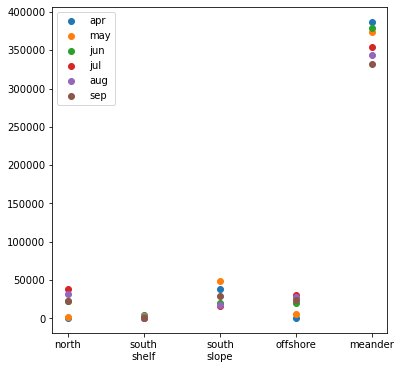

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(sec_name, apr, label='apr')
ax.scatter(sec_name, may, label='may')
ax.scatter(sec_name, jun, label='jun')
ax.scatter(sec_name, jul, label='jul')
ax.scatter(sec_name, aug, label='aug')
ax.scatter(sec_name, sep, label='sep')
ax.legend(loc='upper left')

In [7]:
# overal percentage meander
np.sum([jun[-1],jul[-1],aug[-1],sep[-1]])/np.sum([jun,jul,aug,sep])

0.8232259601830908

### based on analysis later on in this notebook and looking into the TS diagrams the flow can most easily be deliniated based on whether or not it came from the south or the north
similar to what Saurav did for the summer - therefore confirming that his method was useful for that time period! <br>
looking at the timeseries figure of where water is coming from I'm hesitant to use this confidently for april and may, but definitely happy with it for june, july, august, september

In [8]:
mon_sum = [np.sum(apr[:-1]),np.sum(may[:-1]),np.sum(jun[:-1]),np.sum(jul[:-1]),np.sum(aug[:-1]),np.sum(sep[:-1])]

saltdiv = 32
north = [np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]
offshore = [np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]
cuc = [np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]
south = [np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]
fresh = [np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] for i in range(len(sum_start))]

In [9]:
print('north = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('cuc = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('south = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('fresh = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')

north = 28.785348272370246 mSv
offshore = 25.54425258018518 mSv
cuc = 8.065532034610635 mSv
south = 13.18622290976587 mSv
fresh = 0.027651353808426187 mSv


In [10]:
print('cuc deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('cuc shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('south deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth > -200) & (data.init_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('south shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth > -200) & (data.init_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore start deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.final_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('north deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth <= -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('north shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('meander = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')

cuc deep = 0.12298177853723945 mSv
cuc shallow = 7.942550256073397 mSv
south deep = 0.2409989751055626 mSv
south shallow = 12.972875288468734 mSv
offshore deep = 0.4069299092537078 mSv
offshore shallow = 25.137322670931468 mSv
offshore start deep = 7.932662876924874 mSv
north deep = 0.43319825257804107 mSv
north shallow = 28.352150019792198 mSv
meander = 352.1065512482824 mSv


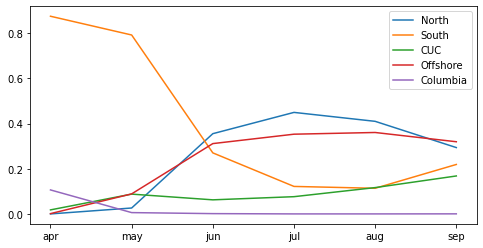

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(monS, north, label = "North")
ax.plot(monS, south, label = "South")
ax.plot(monS, cuc, label = "CUC")
ax.plot(monS, offshore, label='Offshore')
ax.plot(monS, fresh, label = "Columbia")
# ax.plot(monS, meander, label = "Strait Outflow")
ax.legend()

In [12]:
total = np.sum(mon_sum[2:])

north_bar = np.sum([north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100])
offshore_bar = np.sum([offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100])
cuc_bar = np.sum([cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100])
south_bar = np.sum([south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100]) 
fresh_bar = np.sum([fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100]) 

Text(0, 0.5, 'Percentage of JdF Inflow')

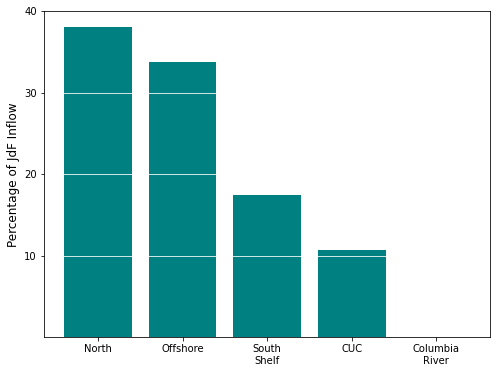

In [13]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = ['North', 'Offshore', 'South\nShelf', 'CUC', 'Columbia\nRiver']
# colors = ['magenta', 'orangered', 'teal', 'midnightblue']
colors = ['teal',  'teal',  'teal', 'teal', 'teal', 'teal']
ax.bar(sec_name,[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar], color=colors)
ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [14]:
[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar]

[38.071321601910995,
 33.784668709189695,
 17.44001595402083,
 10.667422227262588,
 0.036571507615882536]

In [10]:
# north = 28.785348272370246 mSv
# offshore = 25.54425258018518 mSv
# cuc = 8.065532034610635 mSv
# south = 13.18622290976587 mSv
# fresh = 0.027651353808426187 mSv
msv = [28.785348272370246,25.54425258018518,8.065532034610635,13.18622290976587,0.027651353808426187]

#### time to JRT

In [6]:
saltdiv = 32
to_days = 1.15741*10**-14
off_age = data.final_age[(data.final_section==Offshore) & (data.init_t >= sum_start[2]) & (data.init_t <= sum_end[-1])].astype('float')*to_days
north_age = data.final_age[(data.final_section==North) & (data.init_t >= sum_start[2]) & (data.init_t <= sum_end[-1])].astype('float')*to_days
cuc_age = data.final_age[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= sum_start[2]) & (data.init_t <= sum_end[-1])].astype('float')*to_days
south_age = data.final_age[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[2]) & (data.init_t <= sum_end[-1])].astype('float')*to_days
fresh_age = data.final_age[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[2]) & (data.init_t <= sum_end[-1])].astype('float')*to_days

In [7]:
time = -(sum_start[2]) + (sum_end[-1]) + 1
off_tr = data.final_transp[(data.final_section==Offshore) & (data.init_t >= sum_start[2]) & (data.init_t <= sum_end[-1])]/time
north_tr = data.final_transp[(data.final_section==North) & (data.init_t >= sum_start[2]) & (data.init_t <= sum_end[-1])]/time
cuc_tr = data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= sum_start[2]) & (data.init_t <= sum_end[-1])]/time
south_tr = data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[2]) & (data.init_t <= sum_end[-1])]/time
fresh_tr = data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[2]) & (data.init_t <= sum_end[-1])]/time

(0.0, 200.0)

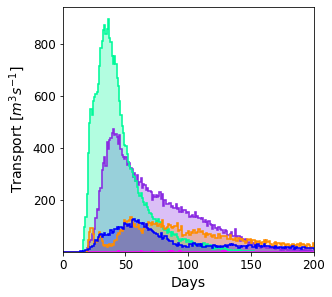

In [8]:
fig, ax = plt.subplots(1,1, figsize = (4.5,4.5))

bins = np.arange(0,300,1)
colours = ['b', 'darkorange', 'magenta', 'mediumspringgreen', 'blueviolet']

n, _, _ = ax.hist([cuc_age,south_age,fresh_age, north_age, off_age], bins=bins, weights=[cuc_tr, south_tr, fresh_tr, north_tr, off_tr], color = colours, label =['CUC', 'South', 'Columbia River', "North", "Offshore"], linewidth = 1.6, histtype='step', stacked=False, zorder=2)
ax.hist([cuc_age,south_age,fresh_age, north_age, off_age], bins=bins, weights=[cuc_tr, south_tr, fresh_tr, north_tr, off_tr], color = colours, histtype='stepfilled', alpha=0.3, stacked=False, zorder=1)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
ax.set_yticks(np.arange(200,801,200))
ax.set_yticklabels(np.arange(200,801,200),fontsize=12)
ax.set_xticks(np.arange(0,201,50))
ax.set_xticklabels(np.arange(0,201,50),fontsize=12);
ax.set_xlim([0,200])

#### lets see how much is meandered from the different groups

In [12]:
saltdiv=32
Mfresh = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]   
Mupwelled = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt > saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]                
Mdeep = [np.sum(data.final_transp[(data.final_section == 0) & (data.final_depth < -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]                

In [16]:
Mmon_sum = np.sum([Mfresh,Mupwelled,Mdeep], axis=0)

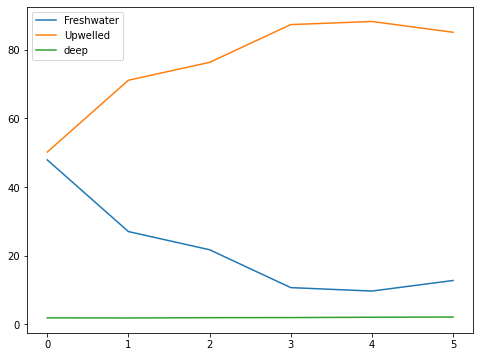

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(Mfresh/Mmon_sum*100, label='Freshwater')
ax.plot(Mupwelled/Mmon_sum*100, label='Upwelled')
ax.plot(Mdeep/Mmon_sum*100, label='deep')
ax.legend()

## winter 2016/17

In [9]:
dataS=data
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')

In [10]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

mon16 = ['oct16', 'nov16', 'dec16', 'jan17', 'feb17', 'mar17']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [10]:
octo16 = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[0])])/(win_end[0]-win_start[0]+1) for sec in sections]
nov16 = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[1]) & (data.init_t <= win_end[1])])/(win_end[1]-win_start[1]+1) for sec in sections]
dec16 = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[2]) & (data.init_t <= win_end[2])])/(win_end[2]-win_start[2]+1) for sec in sections]
jan16 = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[3]) & (data.init_t <= win_end[3])])/(win_end[3]-win_start[3]+1) for sec in sections]
feb16 = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[4]) & (data.init_t <= win_end[4])])/(win_end[4]-win_start[4]+1) for sec in sections]
mar16 = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[5]) & (data.init_t <= win_end[5])])/(win_end[5]-win_start[5]+1) for sec in sections]

In [11]:
sec_name = ['north', 'south\nshelf', 'south\nslope', 'offshore', 'meander']

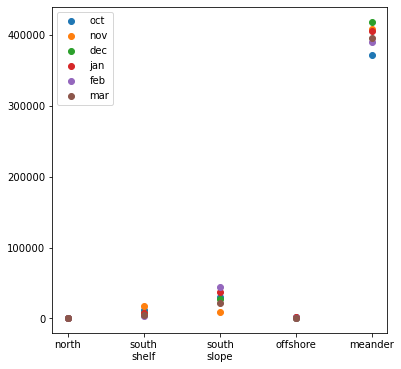

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(sec_name, octo16, label='oct')
ax.scatter(sec_name, nov16, label='nov')
ax.scatter(sec_name, dec16, label='dec')
ax.scatter(sec_name, jan16, label='jan')
ax.scatter(sec_name, feb16, label='feb')
ax.scatter(sec_name, mar16, label='mar')
ax.legend(loc='upper left')

In [14]:
mons = np.append(mon16, ['apr17', 'may17'])
saltdiv = 32.5
# mon_sum = np.append([np.sum(data.final_transp[(data.final_section!=0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))],
#                     [np.sum(dataS.final_transp[(dataS.final_section!=0) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [0,1]])
mon_sum = [np.sum(octo16[:-1]), np.sum(nov16[:-1]), np.sum(dec16[:-1]), np.sum(jan16[:-1]), np.sum(feb16[:-1]), np.sum(mar16[:-1]), np.sum(apr[:-1]), np.sum(may[:-1])]

cuc = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_t >= win_start[i]) & (data.final_depth <= -200) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_depth <= -200) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

south = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.init_t >= win_start[i]) & (data.final_depth > -200) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.init_salt >= saltdiv) & (dataS.init_t >= sum_start[i]) & (dataS.final_depth > -200) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

fresh = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200)& (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.init_salt < saltdiv) & (dataS.final_depth > -200) &(dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

north = np.append([np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==North) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

offshore = np.append([np.sum(data.final_transp[(data.final_section==3) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==3) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

In [15]:
print('north = '+ str(np.mean(north*mon_sum/1000)) + ' mSv')
print('offshore = '+ str(np.mean(offshore*mon_sum/1000)) + ' mSv')
print('cuc = '+ str(np.mean(cuc*mon_sum/1000)) + ' mSv')
print('south = '+ str(np.mean(south*mon_sum/1000)) + ' mSv')
print('fresh = '+ str(np.mean(fresh*mon_sum/1000)) + ' mSv')

north = 0.3141154630447319 mSv
offshore = 1.2298305238659526 mSv
cuc = 1.4269156857979268 mSv
south = 27.171358519484976 mSv
fresh = 11.250389123014452 mSv


In [29]:
print('north = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('offshore = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('cuc = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('south = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('fresh = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')

north = 0.16135867255470182 mSv
offshore = 0.7578868226781977 mSv
cuc = 0.9111797224840742 mSv
south = 22.407815832254737 mSv
fresh = 13.873289497819423 mSv


In [40]:
print('cuc deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('cuc shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('south deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('south shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('offshore deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('offshore shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('offshore start deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.final_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('north deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('north shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('fresh deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')
print('fresh shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')

print('meander = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(6)])/1000) + ' mSv')

cuc deep = 0.019325599872149102 mSv
cuc shallow = 0.8918541226119251 mSv
south deep = 0.5959344278625559 mSv
south shallow = 21.81188140439219 mSv
offshore deep = 0.013546291505999166 mSv
offshore shallow = 0.7443405311721984 mSv
offshore start deep = 0.031224974753504834 mSv
north deep = 0.0033482874546252196 mSv
north shallow = 0.15801038510007664 mSv
fresh deep = 0.0 mSv
fresh shallow = 13.873289497819423 mSv
meander = 398.1857958075713 mSv


In [46]:
np.mean(np.append([np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/1000 for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==0) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/1000 for i in [0,1]]))

390.7458954940291

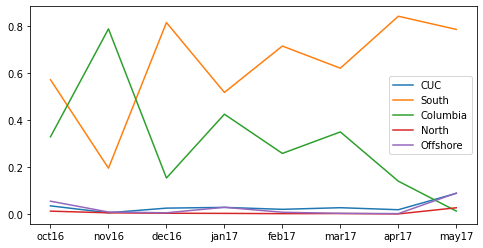

In [13]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(mons, cuc, label = "CUC")
ax.plot(mons, south, label = "South")
ax.plot(mons, fresh, label = "Columbia")
ax.plot(mons, north, label = "North")
ax.plot(mons, offshore, label = "Offshore")
ax.legend()

In [18]:
total = np.sum(mon_sum)
cuc_bar = np.sum([cuc[0]*mon_sum[0]/total*100, cuc[1]*mon_sum[1]/total*100, cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100,cuc[6]*mon_sum[6]/total*100,cuc[7]*mon_sum[7]/total*100])
south_bar = np.sum([south[0]*mon_sum[0]/total*100, south[1]*mon_sum[1]/total*100, south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100,south[6]*mon_sum[6]/total*100,south[7]*mon_sum[7]/total*100])
fresh_bar = np.sum([fresh[0]*mon_sum[0]/total*100, fresh[1]*mon_sum[1]/total*100, fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100,fresh[6]*mon_sum[6]/total*100,fresh[7]*mon_sum[7]/total*100])
north_bar = np.sum([north[0]*mon_sum[0]/total*100, north[1]*mon_sum[1]/total*100, north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100,north[6]*mon_sum[6]/total*100,north[7]*mon_sum[7]/total*100])
offshore_bar = np.sum([offshore[0]*mon_sum[0]/total*100, offshore[1]*mon_sum[1]/total*100, offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100,offshore[6]*mon_sum[6]/total*100,offshore[7]*mon_sum[7]/total*100])


Text(0, 0.5, 'Percentage of JdF Inflow')

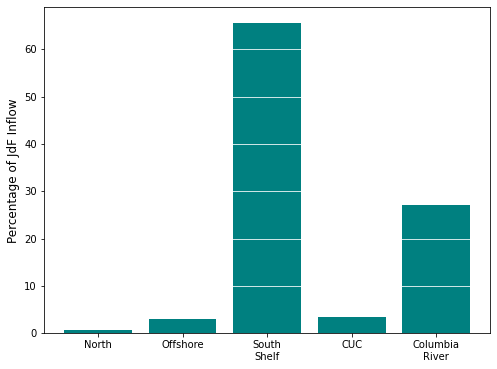

In [19]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = [ 'North', 'Offshore', 'South\nShelf', 'CUC', 'Columbia\nRiver']
colors = ['teal',  'teal',  'teal', 'teal', 'teal']
ax.bar(sec_name,[north_bar, offshore_bar, south_bar ,cuc_bar, fresh_bar], color=colors)
# ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [20]:
[north_bar, offshore_bar, south_bar ,cuc_bar,fresh_bar]

[0.7588684749316418,
 2.971135534125656,
 65.64301929499757,
 3.44727164922571,
 27.17970504671942]

#### time!

In [11]:
saltdiv=32
to_days = 1.15741*10**-14

cuc_age = np.append([data.final_age[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_t >= win_start[0]) & (data.final_depth <= -200) & (data.init_t <= win_end[-1])]],
                [dataS.final_age[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_depth <= -200) & (dataS.init_t >= sum_start[0]) & (dataS.init_t <= sum_end[1])]]).astype('float')*to_days

south_age = np.append([data.final_age[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.init_t >= win_start[0]) & (data.final_depth > -200) & (data.init_t <= win_end[-1])]],
                  [dataS.final_age[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.init_salt >= saltdiv) & (dataS.init_t >= sum_start[0]) & (dataS.final_depth > -200) & (dataS.init_t <= sum_end[1])]]).astype('float')*to_days

fresh_age = np.append([data.final_age[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200)& (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])]],
                  [dataS.final_age[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.init_salt < saltdiv) & (dataS.final_depth > -200) &(dataS.init_t >= sum_start[0]) & (dataS.init_t <= sum_end[1])]]).astype('float')*to_days

north_age = np.append([data.final_age[(data.final_section==North) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])]],
                  [dataS.final_age[(dataS.final_section==North) & (dataS.init_t >= sum_start[0]) & (dataS.init_t <= sum_end[1])]]).astype('float')*to_days

offshore_age = np.append([data.final_age[(data.final_section==3) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])]],
                  [dataS.final_age[(dataS.final_section==3) & (dataS.init_t >= sum_start[0]) & (dataS.init_t <= sum_end[1])]]).astype('float')*to_days

In [12]:
time = win_end[-1]-win_start[0]+sum_end[1]-sum_start[0]+2
cuc_tr = np.append([data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_t >= win_start[0]) & (data.final_depth <= -200) & (data.init_t <= win_end[-1])]],
                [dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_depth <= -200) & (dataS.init_t >= sum_start[0]) & (dataS.init_t <= sum_end[1])]])/time

south_tr = np.append([data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.init_t >= win_start[0]) & (data.final_depth > -200) & (data.init_t <= win_end[-1])]],
                  [dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.init_salt >= saltdiv) & (dataS.init_t >= sum_start[0]) & (dataS.final_depth > -200) & (dataS.init_t <= sum_end[1])]])/time

fresh_tr = np.append([data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200)& (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])]],
                  [dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.init_salt < saltdiv) & (dataS.final_depth > -200) &(dataS.init_t >= sum_start[0]) & (dataS.init_t <= sum_end[1])]])/time

north_tr = np.append([data.final_transp[(data.final_section==North) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])]],
                  [dataS.final_transp[(dataS.final_section==North) & (dataS.init_t >= sum_start[0]) & (dataS.init_t <= sum_end[1])]])/time

offshore_tr = np.append([data.final_transp[(data.final_section==3) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])]],
                  [dataS.final_transp[(dataS.final_section==3) & (dataS.init_t >= sum_start[0]) & (dataS.init_t <= sum_end[1])]])/time

(0.0, 200.0)

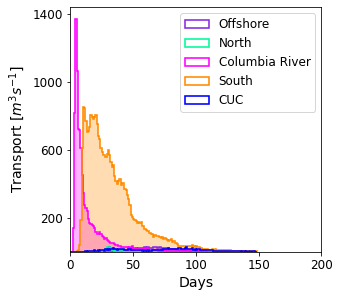

In [14]:
fig, ax = plt.subplots(1,1, figsize = (4.5,4.5))

bins = np.arange(0,150,1)
colours = ['b', 'darkorange', 'magenta', 'mediumspringgreen', 'blueviolet']

n, _, _ = ax.hist([cuc_age,south_age,fresh_age, north_age, offshore_age], bins=bins, weights=[cuc_tr, south_tr, fresh_tr, north_tr, offshore_tr], color = colours, label =['CUC', 'South', 'Columbia River', "North", "Offshore"], linewidth = 1.6, histtype='step', stacked=False, zorder=2)
ax.hist([cuc_age,south_age,fresh_age, north_age, offshore_age], bins=bins, weights=[cuc_tr, south_tr, fresh_tr, north_tr, offshore_tr], color = colours, histtype='stepfilled', alpha=0.3, stacked=False, zorder=1)
ax.legend(fontsize=12)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
ax.set_yticks(np.arange(200,1401,400))
ax.set_yticklabels(np.arange(200,1401,400),fontsize=12)
ax.set_xticks(np.arange(0,201,50))
ax.set_xticklabels(np.arange(0,201,50),fontsize=12);
ax.set_xlim([0,200])
# ax.set_ylim([0,1950])

In [21]:
# lets see how much is meandered from the different groups
saltdiv=32
Mfresh = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]   
Mupwelled = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt > saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]                
Mdeep = [np.sum(data.final_transp[(data.final_section == 0) & (data.final_depth < -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]  

In [22]:
Mmon_sum = np.sum([Mfresh,Mupwelled,Mdeep], axis=0)

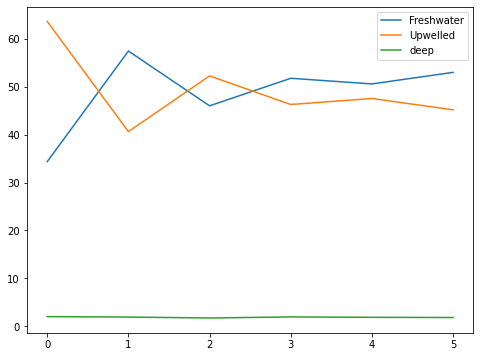

In [23]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(Mfresh/Mmon_sum*100, label='Freshwater')
ax.plot(Mupwelled/Mmon_sum*100, label='Upwelled')
ax.plot(Mdeep/Mmon_sum*100, label='deep')
ax.legend()

## winter 2017/18

In [19]:
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')

In [18]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

mon17 = ['oct17', 'nov17', 'dec17', 'jan18', 'feb18', 'mar18']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [19]:
# sec_name = ['South', 'CUC', 'Columbia\nRiver', 'Strait\nOutflow']
sec_name = ['South', 'CUC', 'Columbia\nRiver', 'Strait\nOutflow','meander']

In [20]:
octo17 = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[0])])/(win_end[0]-win_start[0]+1) for sec in sections]
nov17 = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[1]) & (data.init_t <= win_end[1])])/(win_end[1]-win_start[1]+1) for sec in sections]
dec17 = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[2]) & (data.init_t <= win_end[2])])/(win_end[2]-win_start[2]+1) for sec in sections]
jan17 = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[3]) & (data.init_t <= win_end[3])])/(win_end[3]-win_start[3]+1) for sec in sections]
feb17 = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[4]) & (data.init_t <= win_end[4])])/(win_end[4]-win_start[4]+1) for sec in sections]
mar17 = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[5]) & (data.init_t <= win_end[5])])/(win_end[5]-win_start[5]+1) for sec in sections]

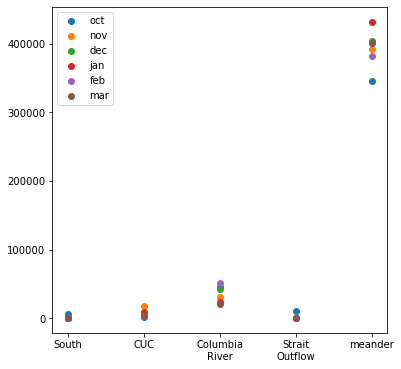

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(sec_name, octo17, label='oct')
ax.scatter(sec_name, nov17, label='nov')
ax.scatter(sec_name, dec17, label='dec')
ax.scatter(sec_name, jan17, label='jan')
ax.scatter(sec_name, feb17, label='feb')
ax.scatter(sec_name, mar17, label='mar')
ax.legend(loc='upper left')

In [17]:
# overal percentage meander
np.sum([octo17[-1],nov17[-1],dec17[-1],jan17[-1],feb17[-1],mar17[-1]])/np.sum([octo17,nov17,dec17,jan17,mar17,feb17])

0.8947123731968932

In [37]:
# mon_sum = [np.sum(data.final_transp[(data.final_section!=0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))]
mon_sum = [np.sum(octo17), np.sum(nov17), np.sum(dec17), np.sum(jan17), np.sum(feb17), np.sum(mar17)]
salt_div = 31.5
cuc = [np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_t >= win_start[i]) & (data.final_depth <= -200) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]
south = [np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= salt_div) & (data.init_t >= win_start[i]) & (data.final_depth > -200) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]
fresh = [np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < salt_div)  & (data.final_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]
north = [np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]
offshore = [np.sum(data.final_transp[(data.final_section==3) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]

In [25]:
print('north = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('offshore = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('cuc = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('south = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('fresh = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')

north = 1.3802585523807231 mSv
offshore = 2.30759253450384 mSv
cuc = 2.373510046561217 mSv
south = 30.43437171254573 mSv
fresh = 9.749409493205969 mSv


In [38]:
print('cuc deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('cuc shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('south deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('south shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('offshore deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('offshore shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('offshore start deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.final_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('north deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('north shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('fresh deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_depth <= -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')
print('fresh shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_depth > -200) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')

print('meander = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==0) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(cuc))])/1000) + ' mSv')

cuc deep = 0.04484482493058107 mSv
cuc shallow = 2.3286652216306365 mSv
south deep = 0.7069647195430726 mSv
south shallow = 29.727406993002656 mSv
offshore deep = 0.036264999543405875 mSv
offshore shallow = 2.271327534960434 mSv
offshore start deep = 0.07138265217474533 mSv
north deep = 0.02312912961191182 mSv
north shallow = 1.3571294227688115 mSv
fresh deep = 0.00555084768922021 mSv
fresh shallow = 9.743858645516749 mSv
meander = 392.98160959128614 mSv


In [41]:
0.04484482493058107+0.7069647195430726+0.036264999543405875+0.02312912961191182+0.00555084768922021

0.8167545213181916

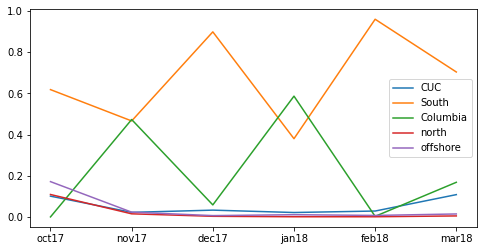

In [40]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(mon17, cuc, label = "CUC")
ax.plot(mon17, south, label = "South")
ax.plot(mon17, fresh, label = "Columbia")
ax.plot(mon17, north, label = "north")
ax.plot(mon17, offshore, label = "offshore")

ax.legend()

In [41]:
total = np.sum(mon_sum)
cuc_bar = np.sum([cuc[0]*mon_sum[0]/total*100, cuc[1]*mon_sum[1]/total*100, cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100]) #,cuc[6]*mon_sum[6]/total*100])
south_bar = np.sum([south[0]*mon_sum[0]/total*100, south[1]*mon_sum[1]/total*100, south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100]) #,cuc[6]*mon_sum[6]/total*100])
fresh_bar = np.sum([fresh[0]*mon_sum[0]/total*100, fresh[1]*mon_sum[1]/total*100, fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100])
north_bar = np.sum([north[0]*mon_sum[0]/total*100, north[1]*mon_sum[1]/total*100, north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100])
offshore_bar = np.sum([offshore[0]*mon_sum[0]/total*100, offshore[1]*mon_sum[1]/total*100, offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100])

Text(0, 0.5, 'Percentage of JdF Inflow')

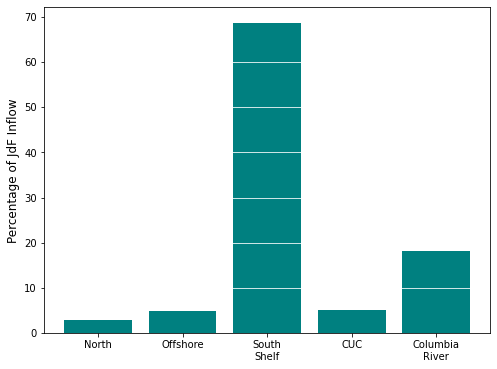

In [42]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = ['North', 'Offshore', 'South\nShelf', 'CUC', 'Columbia\nRiver']
colors = ['teal',  'teal',  'teal', 'teal', 'teal']
ax.bar(sec_name,[north_bar, offshore_bar, south_bar ,cuc_bar, fresh_bar], color=colors)
# ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [43]:
[north_bar, offshore_bar, south_bar ,cuc_bar,fresh_bar]

[2.984656295912864,
 4.989913356906071,
 68.70822307908061,
 5.132452678277142,
 18.184754589823314]

In [47]:
 67.98358680504738 - 65.64301929499757

2.3405675100498087

#### time!

In [20]:
saltdiv = 32
to_days = 1.15741*10**-14
north_age = data.final_age[(data.final_section==Offshore) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])].astype('float')*to_days
off_age = data.final_age[(data.final_section==North) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])].astype('float')*to_days
cuc_age = data.final_age[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])].astype('float')*to_days
south_age = data.final_age[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])].astype('float')*to_days
fresh_age = data.final_age[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])].astype('float')*to_days

In [21]:
time = -(win_start[0]) + (win_end[-1]) + 1
north_tr = data.final_transp[(data.final_section==Offshore) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])]/time
off_tr = data.final_transp[(data.final_section==North) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])]/time
cuc_tr = data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_depth <= -200) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])]/time
south_tr = data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt >= saltdiv) & (data.final_depth > -200) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])]/time
fresh_tr = data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[-1])]/time

(0.0, 200.0)

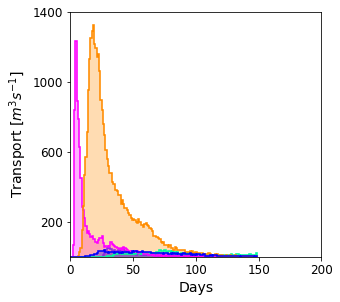

In [26]:
fig, ax = plt.subplots(1,1, figsize = (4.5,4.5))

bins = np.arange(0,150,1)
colours = ['b', 'darkorange', 'magenta', 'mediumspringgreen', 'blueviolet']

n, _, _ = ax.hist([cuc_age,south_age,fresh_age, north_age, off_age], bins=bins, weights=[cuc_tr, south_tr, fresh_tr, north_tr, off_tr], color = colours, label =['CUC', 'South', 'Columbia River', "North", "Offshore"], linewidth = 1.6, histtype='step', stacked=False, zorder=2)
ax.hist([cuc_age,south_age,fresh_age, north_age, off_age], bins=bins, weights=[cuc_tr, south_tr, fresh_tr, north_tr, off_tr], color = colours, histtype='stepfilled', alpha=0.3, stacked=False, zorder=1)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
ax.set_yticks(np.arange(200,1401,400))
ax.set_yticklabels(np.arange(200,1401,400),fontsize=12)
ax.set_xticks(np.arange(0,201,50))
ax.set_xticklabels(np.arange(0,201,50),fontsize=12);
ax.set_xlim([0,200])

In [26]:
# lets see how much is meandered from the different groups
saltdiv=32
Mfresh = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt < saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]   
Mupwelled = [np.sum(data.final_transp[(data.final_section == 0) & (data.init_salt > saltdiv) & (data.final_depth > -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]                
Mdeep = [np.sum(data.final_transp[(data.final_section == 0) & (data.final_depth < -200) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]  

In [27]:
Mmon_sum = np.sum([Mfresh,Mupwelled,Mdeep], axis=0)

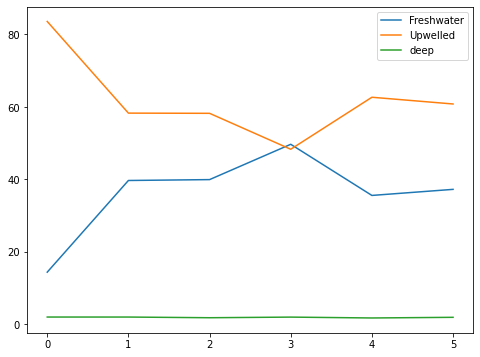

In [28]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(Mfresh/Mmon_sum*100, label='Freshwater')
ax.plot(Mupwelled/Mmon_sum*100, label='Upwelled')
ax.plot(Mdeep/Mmon_sum*100, label='deep')
ax.legend()

### bring it all together - try daily instead of monthly?

In [34]:
mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]

fresh16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt < 32.4) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cuc16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt >= 32.4) & (mydata.final_depth <= -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
south16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt >= 32.4) & (mydata.final_depth > -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
north16 = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshore16 = [np.sum(mydata.final_transp[(mydata.final_section==3) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshoredeep16 = [np.sum(mydata.final_transp[(mydata.final_section==3) & (mydata.final_depth <= -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
 

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(183)]

freshS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt < 32.4) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cucS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt >= 32.4) & (mydata.final_depth <= -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
southS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt >= 32.4) & (mydata.final_depth > -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
northS = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshoreS = [np.sum(mydata.final_transp[(mydata.final_section==3) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshoredeepS = [np.sum(mydata.final_transp[(mydata.final_section==3) & (mydata.final_depth <= -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]

fresh17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt < 32.4) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cuc17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt >= 32.4) & (mydata.final_depth <= -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
south17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.init_salt >= 32.4) & (mydata.final_depth > -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
north17 = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshore17 = [np.sum(mydata.final_transp[(mydata.final_section==3) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshoredeep17 = [np.sum(mydata.final_transp[(mydata.final_section==3) & (mydata.final_depth <= -200) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]


fresh = np.append(np.append(fresh16, freshS), fresh17)
south = np.append(np.append(south16, southS), south17)
north = np.append(np.append(north16, northS), north17)
cuc = np.append(np.append(cuc16, cucS), cuc17)
offshore = np.append(np.append(offshore16, offshoreS), offshore17)
offshoredeep = np.append(np.append(offshoredeep16, offshoredeepS), offshoredeep17)

In [10]:
# dates = [dt.datetime(2016,10,1)+dt.timedelta(days=i) for i in range(len(cuc))]
dates = [dt.datetime(2016,10,1)+dt.timedelta(days=i) for i in range(len(deep_cuc))]

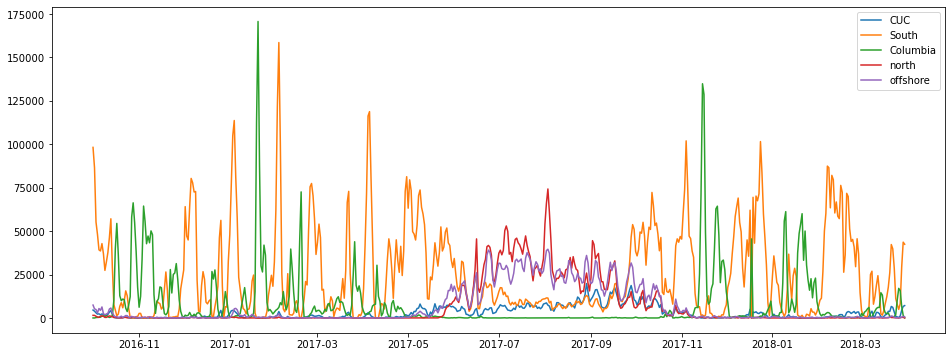

In [7]:
fig, ax = plt.subplots(1,1, figsize=(16,6))

ax.plot(dates, cuc, label = "CUC")
ax.plot(dates, south, label = "South")
ax.plot(dates, fresh, label = "Columbia")
ax.plot(dates, north, label = "north")
ax.plot(dates, offshore, label = "offshore")
ax.legend(loc='upper right')
# ax.set_ylim([0,55000]);

In [23]:
# lets calculate the peason's correlation coefficient between north and offhsore in the summer
corr, _ = pearsonr(north[243:364], offshore[243:364])
print('Pearsons correlation with offshore: %.3f' % corr)
corr, _ = pearsonr(north[243:364], cuc[243:364])
print('Pearsons correlation with cuc: %.3f' % corr)
corr, _ = pearsonr(north[243:364], south[243:364])
print('Pearsons correlation with south: %.3f' % corr)

Pearsons correlation with offshore: 0.726
Pearsons correlation with cuc: 0.023
Pearsons correlation with south: -0.161


In [5]:
# lets calculate the peason's correlation coefficient between north and offhsore in the summer
corr, _ = pearsonr(offshoredeep[243:364], cuc[243:364])
print('Pearsons correlation with offshore: %.3f' % corr)
corr, _ = pearsonr(north[243:364], offshoredeep[243:364])
print('Pearsons correlation with cuc: %.3f' % corr)
# corr, _ = pearsonr(north[243:364], [243:364])
# print('Pearsons correlation with south: %.3f' % corr)

Pearsons correlation with offshore: -0.097
Pearsons correlation with cuc: 0.736


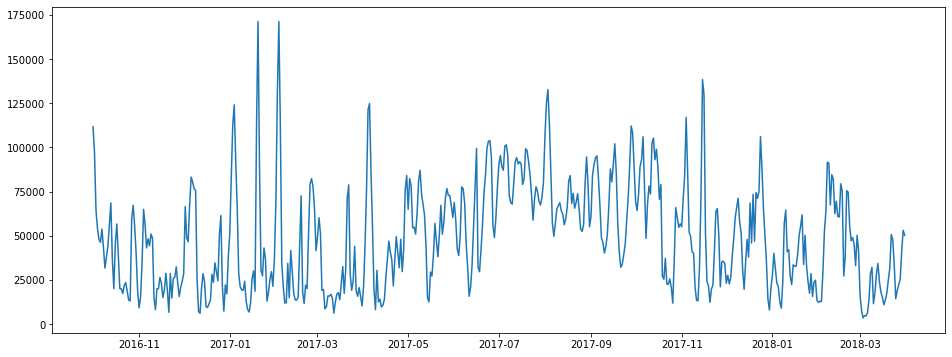

In [48]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
ax.plot(dates, np.sum([cuc,south,fresh,north,offshore],axis=0))
# ax.set_ylim([0,90000]);

## transport weighted histograms of the tracers

In [34]:
Sdata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')

Fapr = (Sdata.init_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[0]) & (Sdata.init_t <= sum_end[0])])/(sum_end[0]-sum_start[0]+1)
Fmay = (Sdata.init_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[1]) & (Sdata.init_t <= sum_end[1])])/(sum_end[1]-sum_start[1]+1)
Fjun = (Sdata.init_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[2]) & (Sdata.init_t <= sum_end[2])])/(sum_end[2]-sum_start[2]+1)
Fjul = (Sdata.init_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[3]) & (Sdata.init_t <= sum_end[3])])/(sum_end[3]-sum_start[3]+1)
Faug = (Sdata.init_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[4]) & (Sdata.init_t <= sum_end[4])])/(sum_end[4]-sum_start[4]+1)
Fsep = (Sdata.init_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[5]) & (Sdata.init_t <= sum_end[5])])/(sum_end[5]-sum_start[5]+1)

Sapr = (Sdata.init_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[0]) & (Sdata.init_t <= sum_end[0])])
Smay = (Sdata.init_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[1]) & (Sdata.init_t <= sum_end[1])])
Sjun = (Sdata.init_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[2]) & (Sdata.init_t <= sum_end[2])])
Sjul = (Sdata.init_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[3]) & (Sdata.init_t <= sum_end[3])])
Saug = (Sdata.init_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[4]) & (Sdata.init_t <= sum_end[4])])
Ssep = (Sdata.init_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[5]) & (Sdata.init_t <= sum_end[5])])

Tapr = (Sdata.init_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[0]) & (Sdata.init_t <= sum_end[0])])
Tmay = (Sdata.init_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[1]) & (Sdata.init_t <= sum_end[1])])
Tjun = (Sdata.init_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[2]) & (Sdata.init_t <= sum_end[2])])
Tjul = (Sdata.init_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[3]) & (Sdata.init_t <= sum_end[3])])
Taug = (Sdata.init_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[4]) & (Sdata.init_t <= sum_end[4])])
Tsep = (Sdata.init_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[5]) & (Sdata.init_t <= sum_end[5])])

In [35]:
Wdata16 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')

Foct16 = (Wdata16.init_transp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[0]) & (Wdata16.init_t <= win_end[0])])/(win_end[0]-win_start[0]+1)
Fnov16 = (Wdata16.init_transp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[1]) & (Wdata16.init_t <= win_end[1])])/(win_end[1]-win_start[1]+1)
Fdec16 = (Wdata16.init_transp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[2]) & (Wdata16.init_t <= win_end[2])])/(win_end[2]-win_start[2]+1)
Fjan16 = (Wdata16.init_transp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[3]) & (Wdata16.init_t <= win_end[3])])/(win_end[3]-win_start[3]+1)
Ffeb16 = (Wdata16.init_transp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[4]) & (Wdata16.init_t <= win_end[4])])/(win_end[4]-win_start[4]+1)
Fmar16 = (Wdata16.init_transp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[5]) & (Wdata16.init_t <= win_end[5])])/(win_end[5]-win_start[5]+1)

Soct16 = (Wdata16.init_salt[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[0]) & (Wdata16.init_t <= win_end[0])])
Snov16 = (Wdata16.init_salt[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[1]) & (Wdata16.init_t <= win_end[1])])
Sdec16 = (Wdata16.init_salt[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[2]) & (Wdata16.init_t <= win_end[2])])
Sjan16 = (Wdata16.init_salt[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[3]) & (Wdata16.init_t <= win_end[3])])
Sfeb16 = (Wdata16.init_salt[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[4]) & (Wdata16.init_t <= win_end[4])])
Smar16 = (Wdata16.init_salt[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[5]) & (Wdata16.init_t <= win_end[5])])

Toct16 = (Wdata16.init_temp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[0]) & (Wdata16.init_t <= win_end[0])])
Tnov16 = (Wdata16.init_temp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[1]) & (Wdata16.init_t <= win_end[1])])
Tdec16 = (Wdata16.init_temp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[2]) & (Wdata16.init_t <= win_end[2])])
Tjan16 = (Wdata16.init_temp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[3]) & (Wdata16.init_t <= win_end[3])])
Tfeb16 = (Wdata16.init_temp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[4]) & (Wdata16.init_t <= win_end[4])])
Tmar16 = (Wdata16.init_temp[(Wdata16.final_section != 0) & (Wdata16.init_t >= win_start[5]) & (Wdata16.init_t <= win_end[5])])

In [36]:
Wdata17 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')

Foct17 = (Wdata17.init_transp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[0]) & (Wdata17.init_t <= win_end[0])])/(win_end[0]-win_start[0]+1)
Fnov17 = (Wdata17.init_transp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[1]) & (Wdata17.init_t <= win_end[1])])/(win_end[1]-win_start[1]+1)
Fdec17 = (Wdata17.init_transp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[2]) & (Wdata17.init_t <= win_end[2])])/(win_end[2]-win_start[2]+1)
Fjan17 = (Wdata17.init_transp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[3]) & (Wdata17.init_t <= win_end[3])])/(win_end[3]-win_start[3]+1)
Ffeb17 = (Wdata17.init_transp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[4]) & (Wdata17.init_t <= win_end[4])])/(win_end[4]-win_start[4]+1)
Fmar17 = (Wdata17.init_transp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[5]) & (Wdata17.init_t <= win_end[5])])/(win_end[5]-win_start[5]+1)

Soct17 = (Wdata17.init_salt[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[0]) & (Wdata17.init_t <= win_end[0])])
Snov17 = (Wdata17.init_salt[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[1]) & (Wdata17.init_t <= win_end[1])])
Sdec17 = (Wdata17.init_salt[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[2]) & (Wdata17.init_t <= win_end[2])])
Sjan17 = (Wdata17.init_salt[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[3]) & (Wdata17.init_t <= win_end[3])])
Sfeb17 = (Wdata17.init_salt[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[4]) & (Wdata17.init_t <= win_end[4])])
Smar17 = (Wdata17.init_salt[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[5]) & (Wdata17.init_t <= win_end[5])])

Toct17 = (Wdata17.init_temp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[0]) & (Wdata17.init_t <= win_end[0])])
Tnov17 = (Wdata17.init_temp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[1]) & (Wdata17.init_t <= win_end[1])])
Tdec17 = (Wdata17.init_temp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[2]) & (Wdata17.init_t <= win_end[2])])
Tjan17 = (Wdata17.init_temp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[3]) & (Wdata17.init_t <= win_end[3])])
Tfeb17 = (Wdata17.init_temp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[4]) & (Wdata17.init_t <= win_end[4])])
Tmar17 = (Wdata17.init_temp[(Wdata17.final_section != 0) & (Wdata17.init_t >= win_start[5]) & (Wdata17.init_t <= win_end[5])])

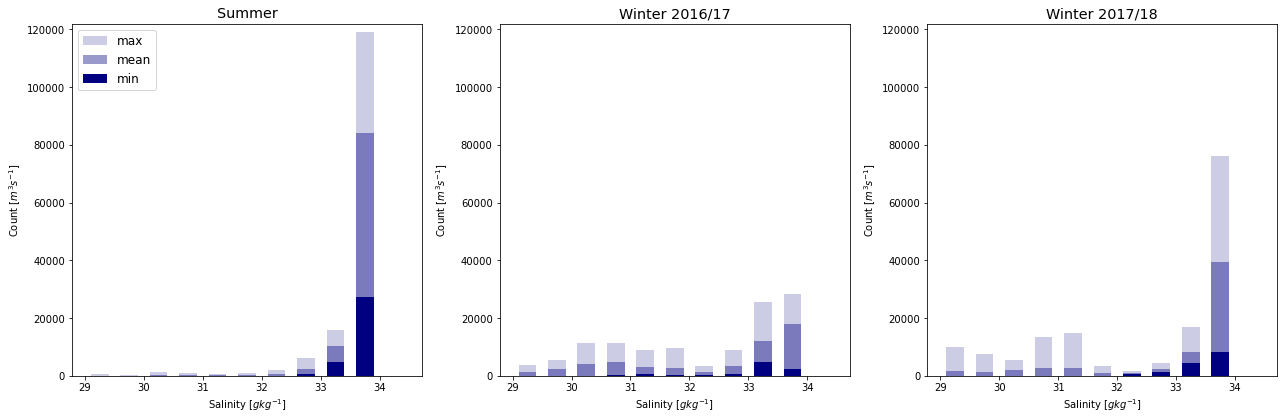

In [37]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))
plt.rcParams['font.size'] = 12
#plt summer
sum_sal,x,_ = ax[0].hist([Sapr, Smay, Sjun, Sjul, Saug, Ssep], bins=np.arange(29,35,0.5), weights= [Fapr, Fmay, Fjun, Fjul, Faug, Fsep],alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(sum_sal,axis=0)
mini = np.min(sum_sal,axis=0)
maxi = np.max(sum_sal,axis=0)

ax[0].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0].set_title('Summer')
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[0].set_xlabel('Salinity [$g kg^{-1}$]')
ax[0].set_ylim([0,122000])
ax[0].legend()

#plt winter
win_sal,x,_ = ax[1].hist([Soct16, Snov16, Sdec16, Sjan16, Sfeb16, Smar16], bins=np.arange(29,35,0.5), weights= [Foct16, Fnov16, Fdec16, Fjan16, Ffeb16, Fmar16],alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(win_sal,axis=0)
mini = np.min(win_sal,axis=0)
maxi = np.max(win_sal,axis=0)

ax[1].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[1].set_title('Winter 2016/17')
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[1].set_xlabel('Salinity [$g kg^{-1}$]')
ax[1].set_ylim([0,122000])

#plt winter
win_sal,x,_ = ax[2].hist([Soct17, Snov17, Sdec17, Sjan17, Sfeb17, Smar17], bins=np.arange(29,35,0.5), weights= [Foct17, Fnov17, Fdec17, Fjan17, Ffeb17, Fmar17],alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(win_sal,axis=0)
mini = np.min(win_sal,axis=0)
maxi = np.max(win_sal,axis=0)

ax[2].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[2].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[2].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[2].set_title('Winter 2017/18')
ax[2].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[2].set_xlabel('Salinity [$g kg^{-1}$]')
ax[2].set_ylim([0,122000])
# ax[1].legend()

plt.tight_layout()

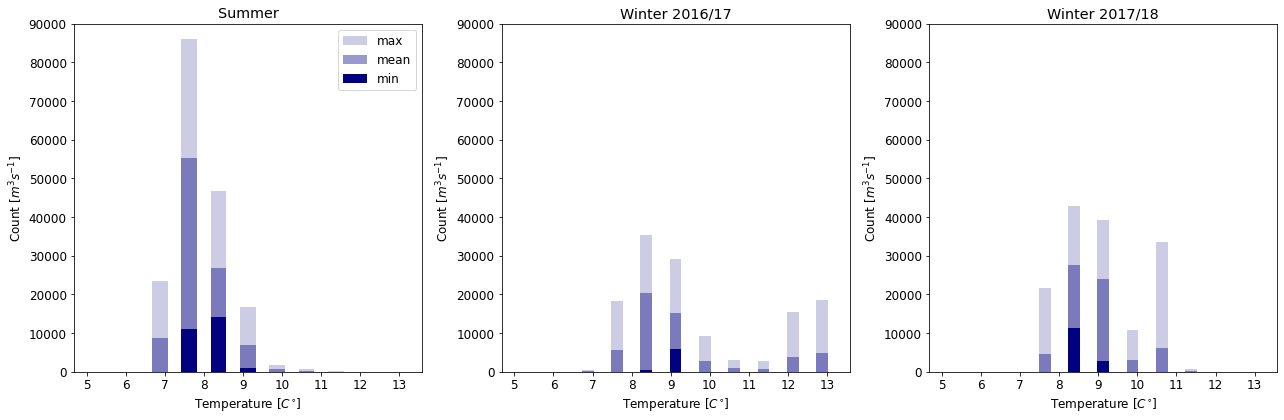

In [38]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))
plt.rcParams['font.size'] = 12
#plt summer
sum_tem,x,_ = ax[0].hist([Tapr, Tmay, Tjun, Tjul, Taug, Tsep], bins=np.arange(5,14,0.75), weights= [Fapr, Fmay, Fjun, Fjul, Faug, Fsep],alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(sum_tem,axis=0)
mini = np.min(sum_tem,axis=0)
maxi = np.max(sum_tem,axis=0)

ax[0].bar(bin_centers,maxi,width = 0.4,color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width = 0.4, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width = 0.4, color='navy',label='min')

ax[0].set_title('Summer')
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[0].set_xlabel('Temperature [$C^{\circ}$]')
ax[0].set_ylim([0,90000])
ax[0].legend()

#plt winter
win_tem,x,_ = ax[1].hist([Toct16, Tnov16, Tdec16, Tjan16, Tfeb16, Tmar16], bins=np.arange(5,14,0.75), weights= [Foct16, Fnov16, Fdec16, Fjan16, Ffeb16, Fmar16],alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(win_tem,axis=0)
mini = np.min(win_tem,axis=0)
maxi = np.max(win_tem,axis=0)

ax[1].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[1].set_title('Winter 2016/17')
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[1].set_xlabel('Temperature [$C^{\circ}$]')
ax[1].set_ylim([0,90000])

#plt winter
win_tem,x,_ = ax[2].hist([Toct17, Tnov17, Tdec17, Tjan17, Tfeb17, Tmar17], bins=np.arange(5,14,0.75), weights= [Foct17, Fnov17, Fdec17, Fjan17, Ffeb17, Fmar17],alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(win_tem,axis=0)
mini = np.min(win_tem,axis=0)
maxi = np.max(win_tem,axis=0)

ax[2].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[2].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[2].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[2].set_title('Winter 2017/18')
ax[2].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[2].set_xlabel('Temperature [$C^{\circ}$]')
ax[2].set_ylim([0,90000])
# ax[1].legend()

plt.tight_layout()

# Cross sections of flow 

In [3]:
mymesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [4]:
Sdata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
Wdata16 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
Wdata17 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')

In [5]:
#in the format [section, igridW, igridE, fjgrid, maxdepth] for horizontal CS
# OR for vertical [section, jgridS, jgridN, figrid, maxdepth]
init = [1,259, 274, 640,250] #v
North = [2, 531, 585, 320, 220] #h
Sshelf = [5, 634, 644, 200, 180] #h
Sslope = [4, 579, 633, 200, 500] #h
offshore = [3, 199, 300, 560, 500] # v

In [6]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(len(t_depths)-1):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', zorder=3)
    return(pc)

In [26]:
def FluxEW(mydata, salfile, tracername, section, lonW, lonE, fjgrid, maxdepth, distlabel, ax, title):
    igrid = fjgrid-1
    fmask = mymesh.fmask[0, :, igrid, :]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    bins = [np.array(t_dist[lonW-1:lonE+1]), t_depths]
    xs, ys = np.meshgrid(np.array(t_dist[lonW-1:lonE+1]), np.array(t_depths))
    
    if type(section) == list:
        lons = mydata.final_lon[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
        dist = lons/m2lon
        depths = depthf(mydata.final_z[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]-1.)[0]
        transports = mydata.final_transp[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]/time
        
        H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths],weights= transports, density= True)
        _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
        if tracername == 'trans':
            t_max = (0.01/np.sum(transports)).values
            tick = np.round(((t_max*sum(transports)).values),2)
            cmap = cm.speed
            units = '$m s^{-1}$'
            
            H_final = H1.T
    
        elif tracername == 'temp' or tracername == 'salt':
            if tracername == 'temp':
                tracer = mydata.init_temp[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
                t_max = round(1 * 0.1,1)
                tick = t_max
                cmap = cm.rain
                units = '$C^{\circ} m s^{-1}$'
            else:
                tracer = mydata.init_salt[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
                t_max = round(15 * 0.1,1)
                tick = t_max
                cmap = cm.amp
                units = '$g kg^{-1} m s^{-1}$'
        
            H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths])
            H_final = H1.T * H.statistic.T * float(sum(transports))
    
        else:
            print('incorrect tracer name, options are trans, salt, temp')
            
    else:
        lons = mydata.final_lon[(mydata.final_section==section)]
        dist = lons/m2lon
        depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
        transports = mydata.final_transp[(mydata.final_section==section)]/time
        
        H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths],weights= transports, density= True)
        _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
        if tracername == 'trans':
            t_max = (0.01/np.sum(transports)).values
            tick = np.round(((t_max*sum(transports)).values),2)
            cmap = cm.speed
            units = '$m \, s^{-1}$'
            
            H_final = H1.T
    
        elif tracername == 'temp' or tracername == 'salt':
            if tracername == 'temp':
                tracer = mydata.init_temp[(mydata.final_section == section)]
                t_max = round(1 * 0.1,1)
                tick = t_max
                cmap = cm.rain
                units = '$C^{\circ} m s^{-1}$'
            else:
                tracer = mydata.init_salt[(mydata.final_section == section)]
                t_max = round(15 * 0.1,1)
                tick = t_max
                cmap = cm.amp
                units = '$g kg^{-1} m s^{-1}$'
        
            H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths])
            H_final = H1.T * H.statistic.T * float(sum(transports))
    
        else:
            print('incorrect tracer name, options are trans, salt, temp')

    X, Y = np.meshgrid(xedges, yedges)
    cmap.set_bad('white')
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick]) 
    cb1.set_label(units, labelpad=-20, fontsize=14)
    
    salinity = 0.5*(np.ma.array(salfile.vosaline[:, igrid, lonW-1:lonE+1],
            mask=1-tmask[:, igrid, lonW-1:lonE+1]) +
            np.ma.array(salfile.vosaline[:, igrid+1, lonW-1:lonE+1],
            mask=1-tmask[:, igrid+1, lonW-1:lonE+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12)
#     ax.legend(fontsize=12)

    if distlabel == True:
        distance = abs(round_to_3((t_dist[lonW-1]-t_dist[lonE+1]).values/1000))
        ax.set_xlabel("Cross-section width = "+str(distance)[:-2]+" km", fontsize=14)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW], t_dist[lonE-1]])
    ax.set_xticklabels(np.round([t_lons[lonW], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW], t_dist[lonE-1]))
    ax.set_ylim((maxdepth, 0))
    full_title = str(title)+" - "+str(round_to_2(np.sum(transports).values))[:-2]+" $m^3 \, s^{-1}$"
    ax.set_title(str(full_title), fontsize=14)
    ax.set_ylabel('Depth [m]', fontsize=14)
    mydata.close()
    
    return t_dist

In [25]:
def FluxNS(mydata, salfile, tracername, section, latS, latN, figrid, maxdepth, distlabel, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist[latS-1:latN+1]), np.array(t_depths))
    
    lats = mydata.final_lat[(mydata.final_section==section)]
    dist = lats/m2lat
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    bins = [np.array(t_dist[latS-1:latN+1]), t_depths]
    H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
    if tracername == 'trans':
        t_max = (0.01/np.sum(transports)).values
        tick = np.round(((t_max*sum(transports)).values),2)
        cmap = cm.speed
        units = '$m \, s^{-1}$'
        
        H_final = H1.T
    
    elif tracername == 'temp' or tracername == 'salt':
        if tracername == 'temp':
            tracer = mydata.init_temp[(mydata.final_section == section)]
            t_max = round(1 * 0.1,1)
            tick = t_max
            cmap = cm.rain
            units = '$C^{\circ} m s^{-1}$'
        else:
            tracer = mydata.init_salt[(mydata.final_section == section)]
            t_max = round(15 * 0.1,1)
            tick = t_max
            cmap = cm.amp
            units = '$g kg^{-1} m s^{-1}$'
        
        H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
        H_final = H1.T * H.statistic.T * float(sum(transports))
    
    else:
        print('incorrect tracer name, options are trans, salt, temp')
    
    if section == 3:
        h= H_final
        h[:,19] = H_final[:,19]/15
        h[:,20] = H_final[:,20]/15
        h[:,21] = H_final[:,21]/10
        h[:,41] = H_final[:,41]/10
        h[:,61] = H_final[:,61]/8
        h[:,62] = H_final[:,62]/8
        h[:,83] = H_final[:,83]/10
        h[:,84] = H_final[:,84]/10
        H_final = np.where(h>0, h, h*np.nan)
    else:
        H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick], fontsize=12)
    cb1.set_label(units, labelpad=-20, fontsize=14)
    
    if distlabel == True:
        distance = abs(round_to_3((t_dist[latS-1]-t_dist[latN+1]).values/1000))
        ax.set_xlabel("Cross-section width = "+str(distance)[:-2]+" km", fontsize=14)
    
    salinity = 0.5*(np.ma.array(salfile.vosaline[:, latS-1:latN+1, igrid],
        mask=1-tmask[:, latS-1:latN+1, igrid]) +
        np.ma.array(salfile.vosaline[:, latS-1:latN+1, igrid+1],
        mask=1-tmask[:, latS-1:latN+1, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12)
#     ax.legend(fontsize=12)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
    full_title = str(title)+" - "+str(round_to_2(np.sum(transports).values))[:-2]+" $m^3 \, s^{-1}$"
    ax.set_title(str(full_title), fontsize=16)
    ax.set_ylabel('Depth [m]', fontsize=14)
    mydata.close()

In [9]:
salfileS17 = xr.open_dataset('/ocean/rbeutel/data/S_avg_20170401_20170930.nc')
salfileW16 = xr.open_dataset('/ocean/rbeutel/data/S_avg_20161001_20170331.nc')
salfileW17 = xr.open_dataset('/ocean/rbeutel/data/S_avg_20171001_20180331.nc')

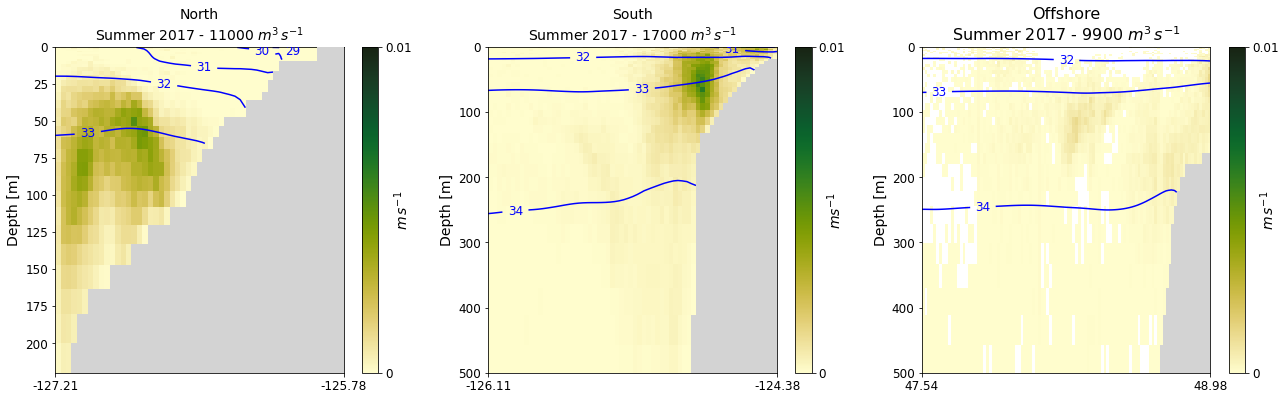

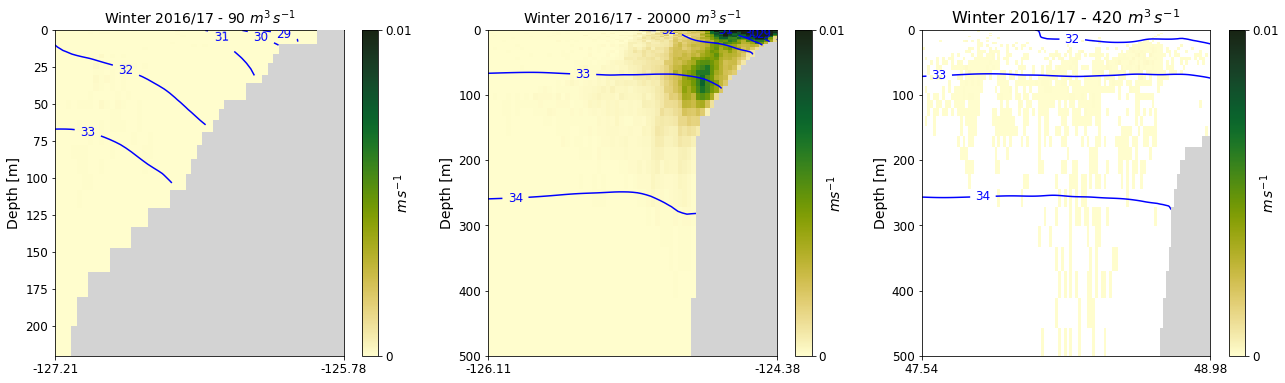

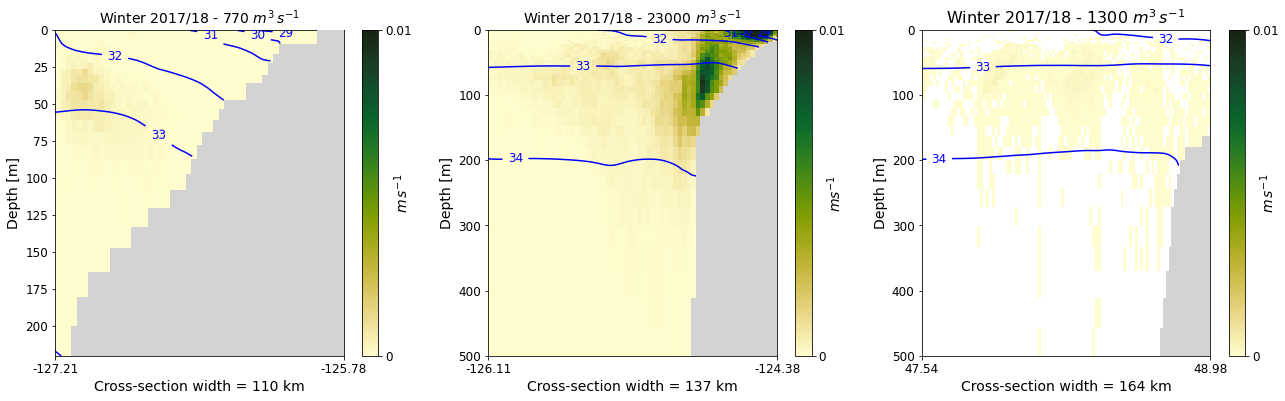

In [35]:
# one presentable figure with all the offshore stuff for the three seasons togetha
plt.rcParams['font.size'] = 12

distlabel = False
fig, ax = plt.subplots(1,3, figsize=[22,6])
t_dist = FluxEW(Sdata, salfileS17, 'trans', North[0], North[1], North[2], North[3], North[4], distlabel, ax[0], 'North\nSummer 2017')
t_dist = FluxEW(Sdata, salfileS17, 'trans', [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax[1], 'South\nSummer 2017')
FluxNS(Sdata, salfileS17, 'trans', offshore[0], offshore[1], offshore[2], offshore[3], offshore[4], distlabel, ax[2], 'Offshore\nSummer 2017')

fig, ax = plt.subplots(1,3, figsize=[22,6])
t_dist = FluxEW(Wdata16, salfileW16, 'trans', North[0], North[1], North[2], North[3], North[4], distlabel, ax[0], 'Winter 2016/17')
t_dist = FluxEW(Wdata16, salfileW16, 'trans', [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax[1], 'Winter 2016/17')
FluxNS(Wdata16, salfileW16, 'trans', offshore[0], offshore[1], offshore[2], offshore[3], offshore[4], distlabel, ax[2], 'Winter 2016/17')

distlabel = True
fig, ax = plt.subplots(1,3, figsize=[22,6])
t_dist = FluxEW(Wdata17, salfileW17, 'trans', North[0], North[1], North[2], North[3], North[4], distlabel, ax[0], 'Winter 2017/18')
t_dist = FluxEW(Wdata17, salfileW17, 'trans', [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax[1], 'Winter 2017/18')
FluxNS(Wdata17, salfileW17, 'trans', offshore[0], offshore[1], offshore[2], offshore[3], offshore[4], distlabel, ax[2], 'Winter 2017/18')

In [47]:
def JRFluxNS(mydata, salfile, tracername,latS, latN, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    lats = mydata.init_lat[(mydata.final_section != 0)]
    dist = lats/m2lat
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    bins = [np.array(t_dist[latS-1:latN+1]), t_depths]
    H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
    if tracername == 'trans':
        t_max = (0.05/np.sum(transports)).values
        tick = np.round(((t_max*sum(transports)).values),2)
        cmap = cm.speed
        units = '$m s^{-1}$'
        
        H_final = H1.T
    
    elif tracername == 'temp' or tracername == 'salt':
        if tracername == 'temp':
            tracer = mydata.init_temp[(mydata.final_section != 0)]
            t_max = round(1 * 0.1,1)
            tick = t_max
            cmap = cm.rain
            units = '$C^{\circ} m s^{-1}$'
        else:
            tracer = mydata.init_salt[(mydata.final_section != 0)]
            t_max = round(15 * 0.1,1)
            tick = t_max
            cmap = cm.amp
            units = '$g kg^{-1} m s^{-1}$'
        
        H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
        H_final = H1.T * H.statistic.T * float(sum(transports))
    
    else:
        print('incorrect tracer name, options are trans, salt, temp')
    
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick])
    cb1.set_label(units, labelpad=-20)
    
    salinity = 0.5*(np.ma.array(salfile.vosaline[0, :, :, igrid],
        mask=1-tmask[:, :, igrid]) +
        np.ma.array(salfile.vosaline[0, :, :, igrid+1],
        mask=1-tmask[:, :, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,34.5, 0.5), colors='b', zorder = 2)
    ax.clabel(CS, inline=1, fontsize=7)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    ax.set_ylabel('Depth [m]')
    mydata.close()

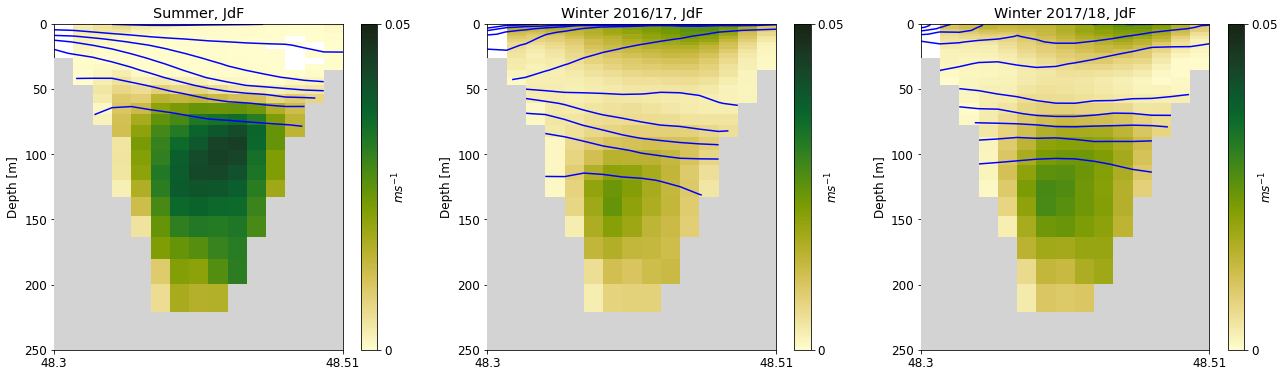

In [48]:
fig, ax = plt.subplots(1,3, figsize=[22,6])
JRFluxNS(Sdata, salfileS17, 'trans', init[1], init[2], init[3], init[4], ax[0], 'Summer, JdF')
JRFluxNS(Wdata16, salfileW16, 'trans', init[1], init[2], init[3], init[4], ax[1], 'Winter 2016/17, JdF')
JRFluxNS(Wdata17, salfileW17, 'trans', init[1], init[2], init[3], init[4], ax[2], 'Winter 2017/18, JdF')

## does our seperation of temperature and salinity of the water going in tell us anything about where the water came from?

In [21]:
def FluxSpecificEW(lonW, lonE, figrid, maxdepth, ax, lons, trans, depth, high):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid, :]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    bins = [np.array(t_dist[lonW-1:lonE+1]), t_depths]
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    t_max = (high/np.sum(trans)).values

    dist = lons/m2lon
        
    H1, _, _ = np.histogram2d(dist, depth, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths],weights= trans, density= True)
    _, xedges, yedges = np.histogram2d(dist, depth, bins = bins)
            
    H_final = H1.T
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.speed
    cmap.set_bad('white')
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    tick = np.round(((t_max*np.sum(trans)).values),2)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick]) 
    cb1.set_label('m/s', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW], t_dist[lonE-1]])
    ax.set_xticklabels(np.round([t_lons[lonW], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW], t_dist[lonE-1]))
    ax.set_ylim((maxdepth, 0))
    # ax.set_title(str(title))
    ax.set_ylabel('Depth [m]')
    mydata.close()

In [28]:
def FluxSpecificNS(latS, latN, fjgrid, maxdepth, ax, lats, trans, depth, high, salfile):
    jgrid = fjgrid-1
    fmask = mymesh.fmask[0, :, : ,jgrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[jgrid]
    time = mydata.init_t[-1]
    
    t_lats = mymesh.gphit[0, :, jgrid]
    m2lat = ((t_lats[latN]-t_lats[latS])/(mymesh.e2t[0, latS:latN, jgrid].sum()))
    t_dist = t_lats/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    bins = [np.array(t_dist[latS-1:latN+1]), t_depths]
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    t_max = (high/np.sum(trans)).values

    dist = lats/m2lat
        
    H1, _, _ = np.histogram2d(dist, depth, bins=bins,weights= trans, density= True)
    _, xedges, yedges = np.histogram2d(dist, depth, bins = bins)
            
    H_final = H1.T
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.speed
    cmap.set_bad('white')
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    tick = np.round(((t_max*np.sum(trans)).values),2)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick]) 
    cb1.set_label('$m \, s^{-1}$', labelpad=-20, fontsize=14)
    
    xs, ys = np.meshgrid(np.array(t_dist[latS-1:latN+1]), np.array(t_depths))
    salinity = 0.5*(np.ma.array(salfile.vosaline[:, latS-1:latN+1, jgrid],
    mask=1-tmask[:, latS-1:latN+1, jgrid]) +
    np.ma.array(salfile.vosaline[:, latS-1:latN+1, jgrid+1],
    mask=1-tmask[:, latS-1:latN+1, jgrid+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,36, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[latS+1], t_dist[latN-2]])
    if latS == 259:
        ax.set_xticklabels(['USA','Canada'], fontsize=12)
    else:
        ax.set_xticklabels(np.round([t_lats[latS+1], t_lats[latN-2]],2))
    ax.set_xlim((t_dist[latS], t_dist[latN-1]))
    ax.set_ylim((maxdepth, 0))
    # ax.set_title(str(title))
    ax.set_ylabel('Depth [m]', fontsize=14)
    mydata.close()

### deep - salty salty

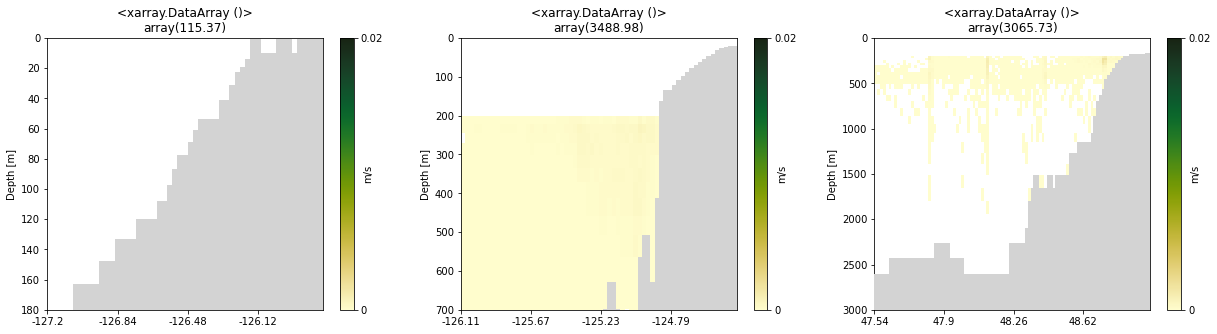

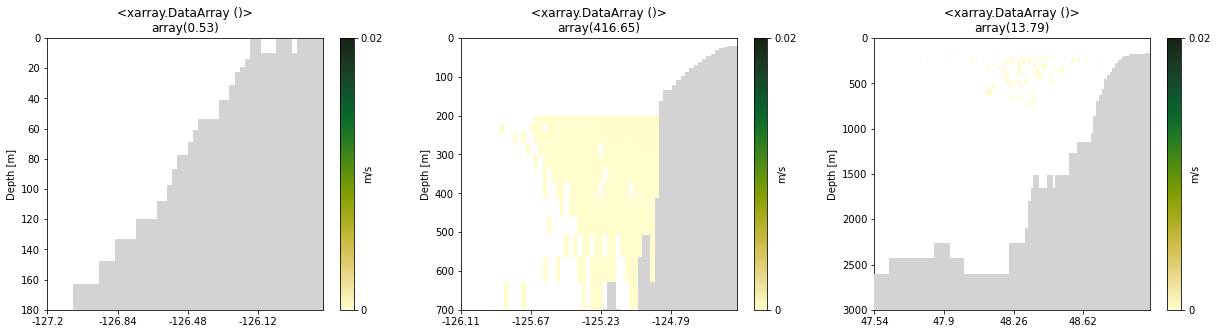

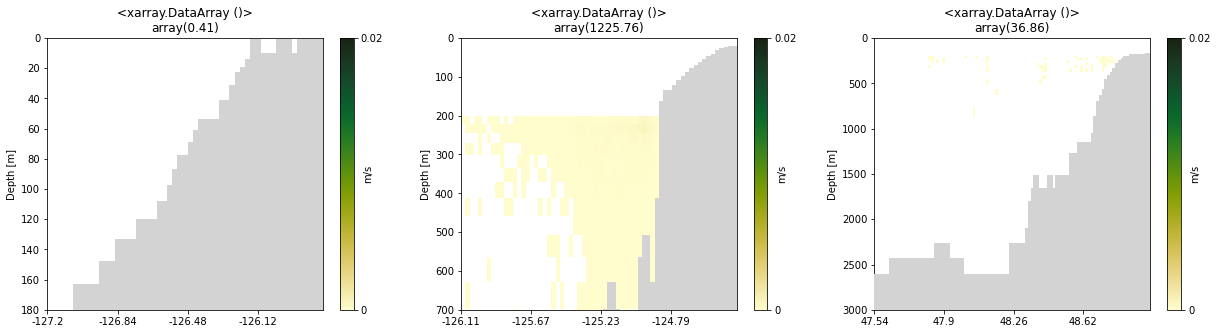

In [45]:
#summer 2017
high = 0.02
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, high)


#winter 2016/17
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, high)

#winter 2017/18
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth <= -200) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, high)

### shallow - salty salty

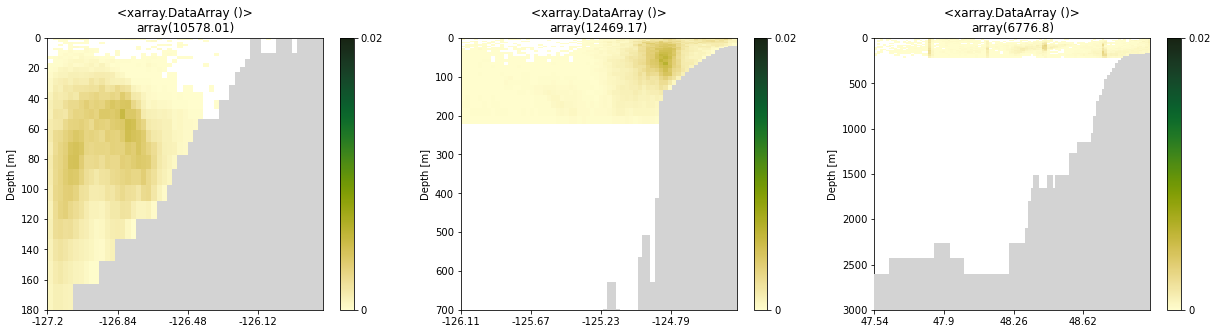

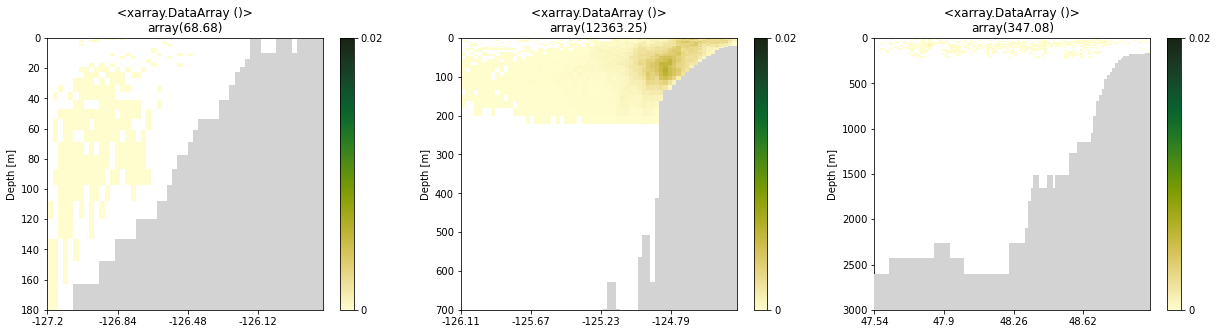

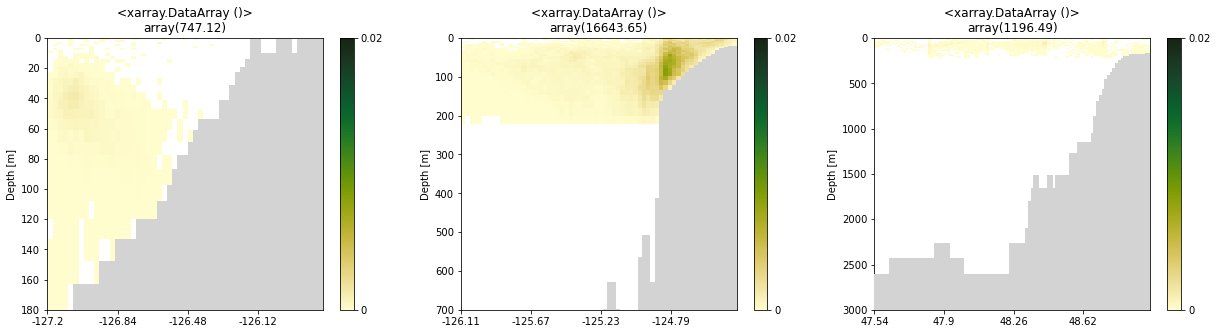

In [78]:
#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.02)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.02)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.02)


#winter 2016/17
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.02)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.02)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.02)

#winter 2017/18
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.02)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.02)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.02)

### fresh - summer only

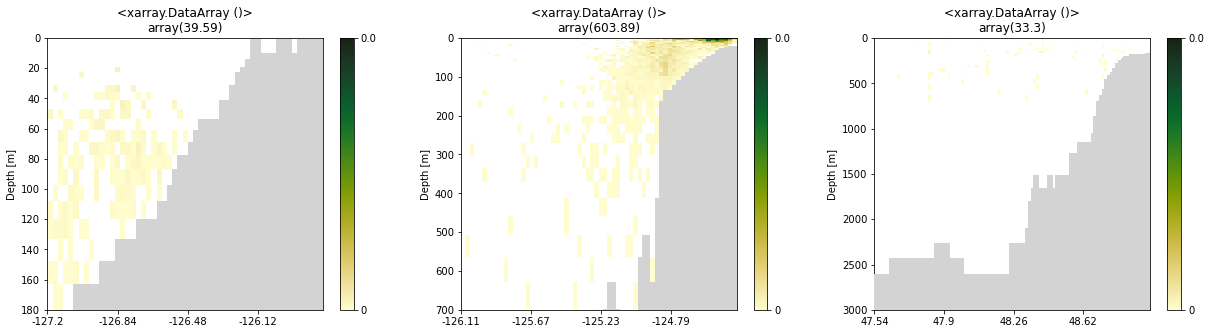

In [7]:
#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt <= 32.4) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt <= 32.4) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= 32.4) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.002)

lons = mydata.final_lon[(mydata.init_salt < 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.002)

lats = mydata.final_lat[(mydata.init_salt <= 32.4) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt <= 32.4) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= 32.4) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.002)

### fresh and warm - winter only

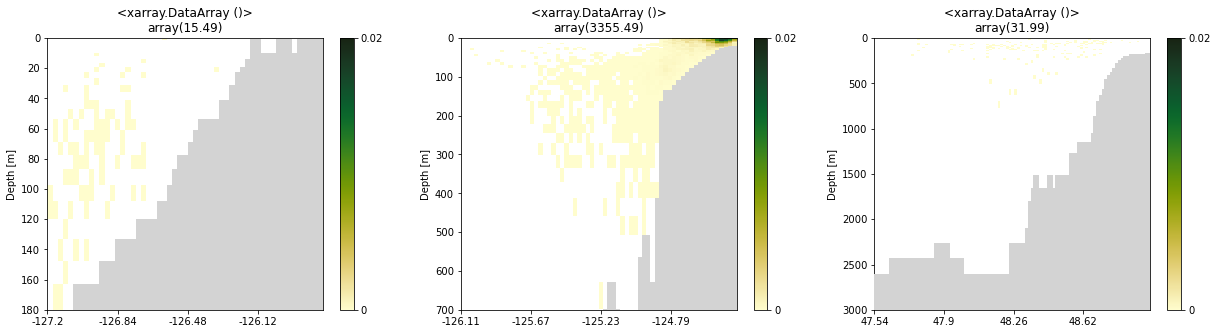

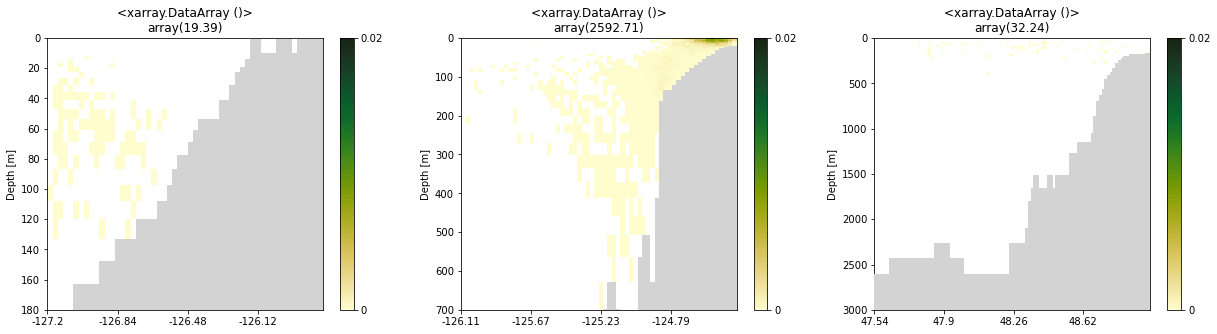

In [33]:
#winter 2016/17
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_temp > 10.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_temp > 10.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_temp > 10.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.02)

lons = mydata.final_lon[(mydata.init_temp > 10.7) & (mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_temp > 10.7) & (mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_temp > 10.7) & (mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.02)

lats = mydata.final_lat[(mydata.init_temp > 10.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_temp > 10.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_temp > 10.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.02)

#winter 2017/18
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_temp > 9.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_temp > 9.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_temp > 9.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.02)

lons = mydata.final_lon[(mydata.init_temp > 9.7) & (mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_temp > 9.7) & (mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_temp > 9.7) & (mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.02)

lats = mydata.final_lat[(mydata.init_temp > 9.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_temp > 9.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_temp > 9.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.02)

### fresh and cool - winter only

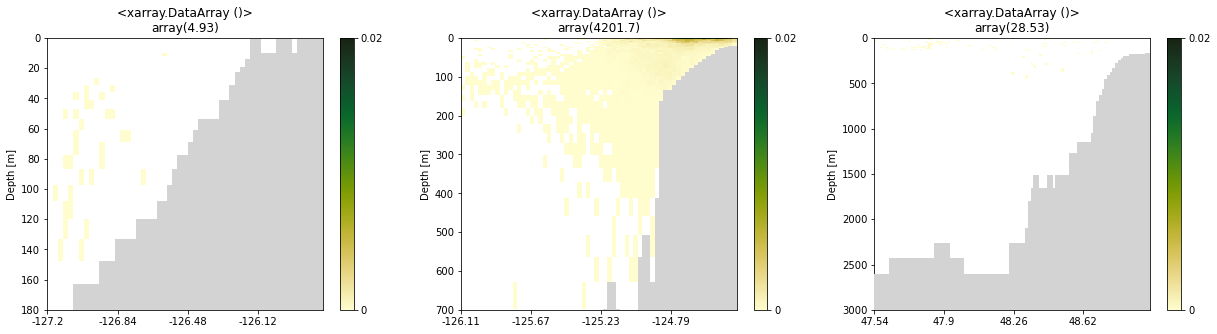

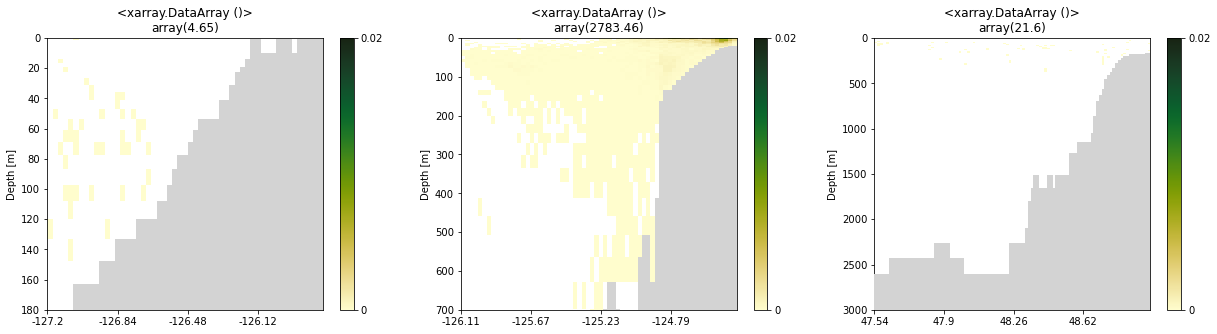

In [34]:
#winter 2016/17
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_temp <= 10.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_temp <= 10.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_temp <= 10.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.02)

lons = mydata.final_lon[(mydata.init_temp <= 10.7) & (mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_temp <= 10.7) & (mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_temp <= 10.7) & (mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.02)

lats = mydata.final_lat[(mydata.init_temp <= 10.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_temp <= 10.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_temp <= 10.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.02)

#winter 2017/18
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_temp <= 9.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_temp <= 9.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_temp <= 9.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 2)]/time
title = np.round(np.sum(trans),2)
ax[0].set_title(title)
FluxSpecificEW(North[1], North[2], North[3], North[4], ax[0], lons, trans, depth, 0.02)

lons = mydata.final_lon[(mydata.init_temp <= 9.7) & (mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]
depth = depthf(mydata.final_z[(mydata.init_temp <= 9.7) & (mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]-1.)[0]
trans = mydata.final_transp[(mydata.init_temp <= 9.7) & (mydata.init_salt <= 32.4) & np.logical_or(mydata.final_section==4,mydata.final_section==5)]/time
title = np.round(np.sum(trans),2)
ax[1].set_title(title)
FluxSpecificEW(Sslope[1], Sshelf[2], Sshelf[3], Sslope[4], ax[1], lons, trans, depth, 0.02)

lats = mydata.final_lat[(mydata.init_temp <= 9.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_temp <= 9.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_temp <= 9.7) & (mydata.init_salt <= 32.4) & (mydata.final_section == 3)]/time
title = np.round(np.sum(trans),2)
ax[2].set_title(title)
FluxSpecificNS(offshore[1], offshore[2], offshore[3], offshore[4], ax[2], lats, trans, depth, 0.02)

## Where do these different groups enter JdF??

In [36]:
Sslope

[4, 579, 633, 200, 700]

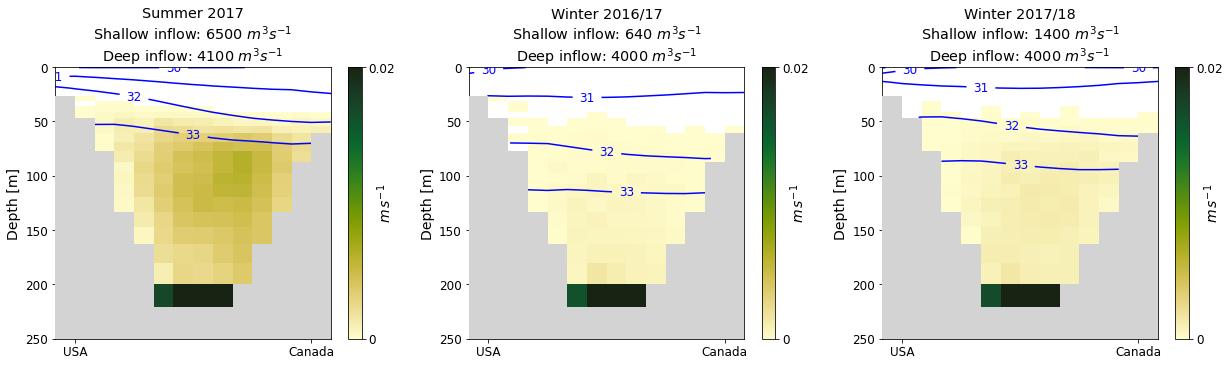

In [34]:
# deep salty salty
plt.rcParams['font.size'] = 12
salt = 32

#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]
depth = depthf(mydata.init_z[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]/time
title = "Summer 2017\nShallow inflow: " + str(round_to_2(np.sum(trans[depth<200]).values))[:-2] + " $m^3 s^{-1}$"+ "\nDeep inflow: "+ str(round_to_2(np.sum(trans[depth>=200]).values))[:-2] + " $m^3 s^{-1}$"
ax[0].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02, salfileS17)


# winter 2016/17

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]
depth = depthf(mydata.init_z[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]/time
title = "Winter 2016/17\nShallow inflow: " + str(round_to_2(np.sum(trans[depth<200]).values))[:-2] + " $m^3 s^{-1}$"+ "\nDeep inflow: "+ str(round_to_2(np.sum(trans[depth>=200]).values))[:-2] + " $m^3 s^{-1}$"
ax[1].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02, salfileW16)

#winter 2017/18

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]
depth = depthf(mydata.init_z[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt > salt) & (mydata.final_depth <= -200)]/time
title = "Winter 2017/18\nShallow inflow: " + str(round_to_2(np.sum(trans[depth<200]).values))[:-2] + " $m^3 s^{-1}$"+ "\nDeep inflow: "+ str(round_to_2(np.sum(trans[depth>=200]).values))[:-2] + " $m^3 s^{-1}$"
ax[2].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02, salfileW17)

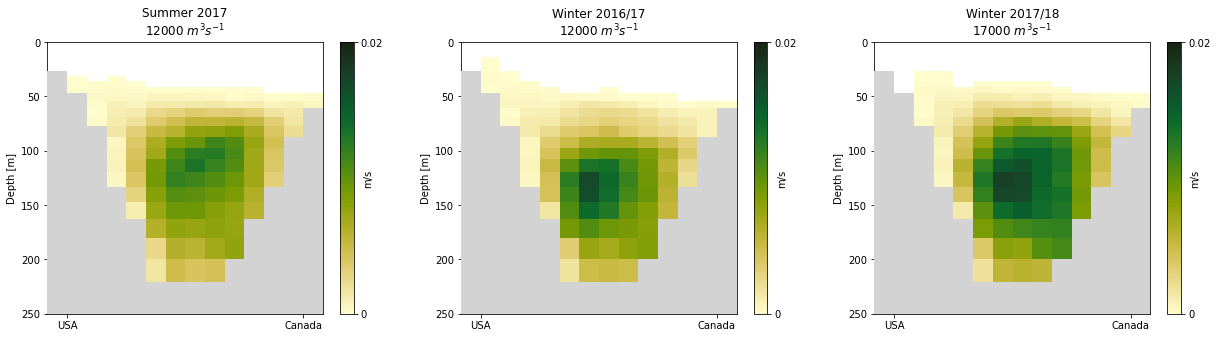

In [71]:
# shallow salty salty

#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

# lats = mydata.init_lat[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]
# depth = depthf(mydata.init_z[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]-1.)[0]
# trans = mydata.init_transp[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]/time
title = "Summer 2017\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02)


#winter 2016/17

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]
depth = depthf(mydata.init_z[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]-1.)[0]
trans = mydata.init_transp[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]/time
title = "Winter 2016/17\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02)

#winter 2017/18

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]
depth = depthf(mydata.init_z[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]-1.)[0]
trans = mydata.init_transp[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]/time
title = "Winter 2017/18\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[2].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02)

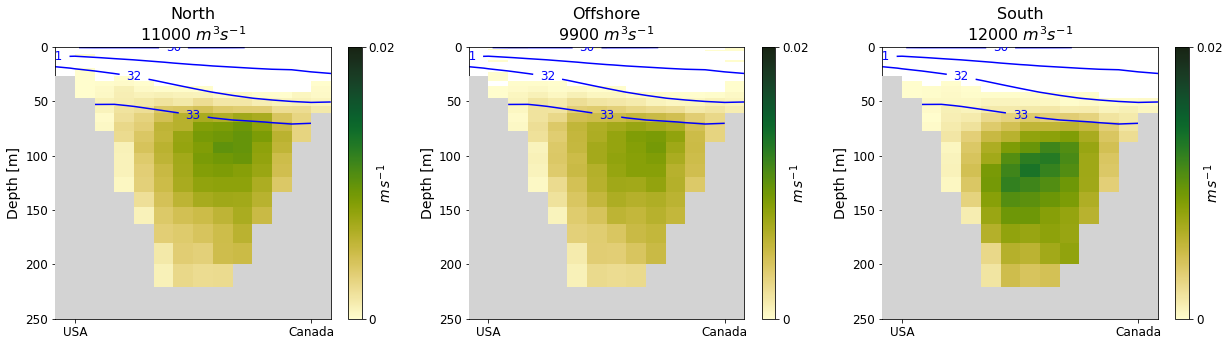

In [32]:
# do the shallow salty salty from different directions in the summer of 2017 enter the JdF differently????
# shallow salty salty
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.final_section == North[0])]
depth = depthf(mydata.init_z[(mydata.final_section == North[0])]-1.)[0]
trans = mydata.init_transp[(mydata.final_section == North[0])]/time
title = "North\n"  + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$"  
ax[0].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02, salfileS17)

lats = mydata.init_lat[(mydata.final_section == offshore[0])]
depth = depthf(mydata.init_z[(mydata.final_section == offshore[0])]-1.)[0]
trans = mydata.init_transp[(mydata.final_section == offshore[0])]/time
title = "Offshore\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02, salfileS17)

lats = mydata.init_lat[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
title = "South\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[2].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02, salfileS17)

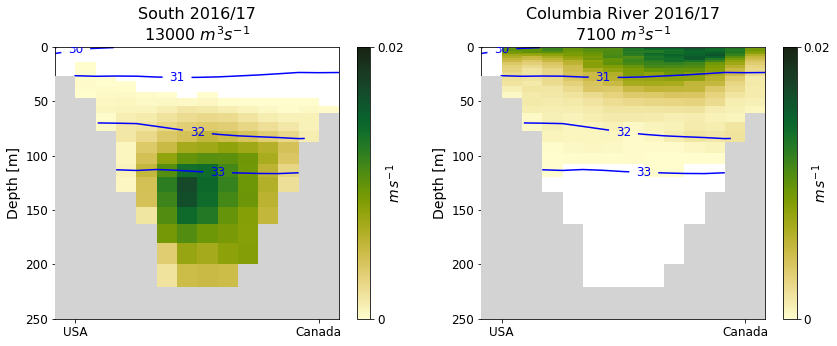

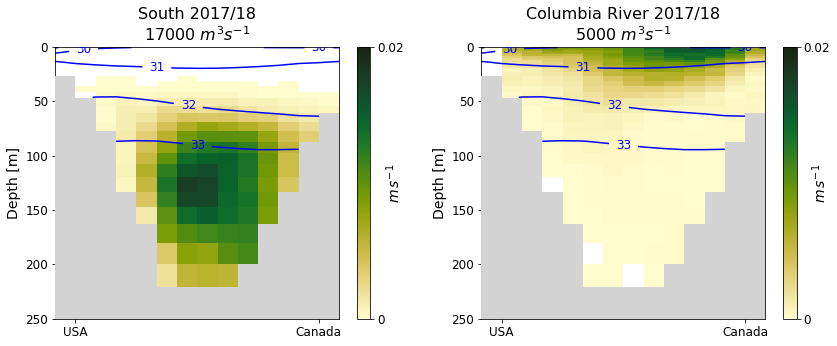

In [33]:
# one plot of fresh and south entering JdF in the winter
# 2016/17
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(1,2,figsize=(14,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt >= 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt >= 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt >= 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
# title = "South\n" + str(np.round(np.sum(trans),0).values)
title = "South 2016/17\n"+ str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02, salfileW16)

lats = mydata.init_lat[(mydata.init_salt < 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt < 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt < 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
# title = "Columbia River\n" + str(np.round(np.sum(trans),0).values)
title = "Columbia River 2016/17\n"+ str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02, salfileW16)

# 2017/18
fig, ax = plt.subplots(1,2,figsize=(14,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt >= 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt >= 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt >= 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
# title = "South\n" + str(np.round(np.sum(trans),0).values)
title = "South 2017/18\n"+ str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02, salfileW17)

lats = mydata.init_lat[(mydata.init_salt < 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt < 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt < 32) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
# title = "Columbia River\n" + str(np.round(np.sum(trans),0).values)
title = "Columbia River 2017/18\n"+ str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02, salfileW17)

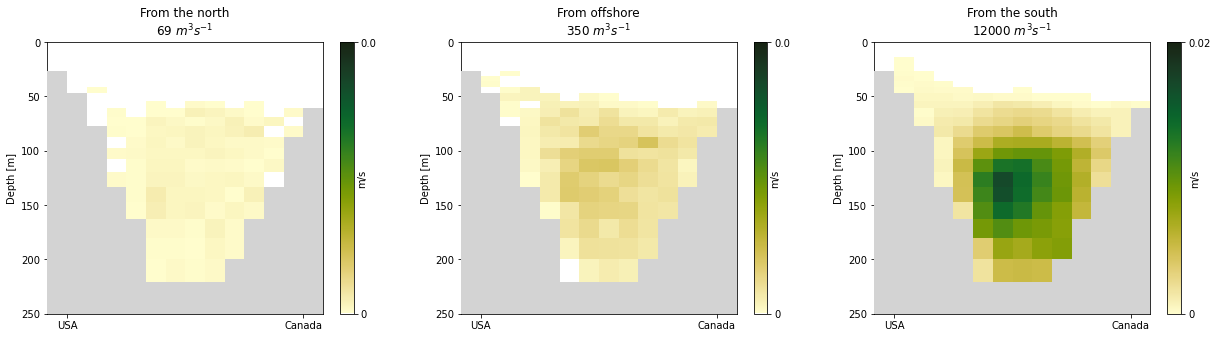

In [75]:
# do these enter in the same locaiton in the winter?
# 2017/18
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == North[0])]
depth = depthf(mydata.init_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == North[0])]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == North[0])]/time
title = "From the north\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.002)

lats = mydata.init_lat[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == offshore[0])]
depth = depthf(mydata.init_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == offshore[0])]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & (mydata.final_section == offshore[0])]/time
title = "From offshore\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.002)

lats = mydata.init_lat[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
title = "From the south\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[2].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02)

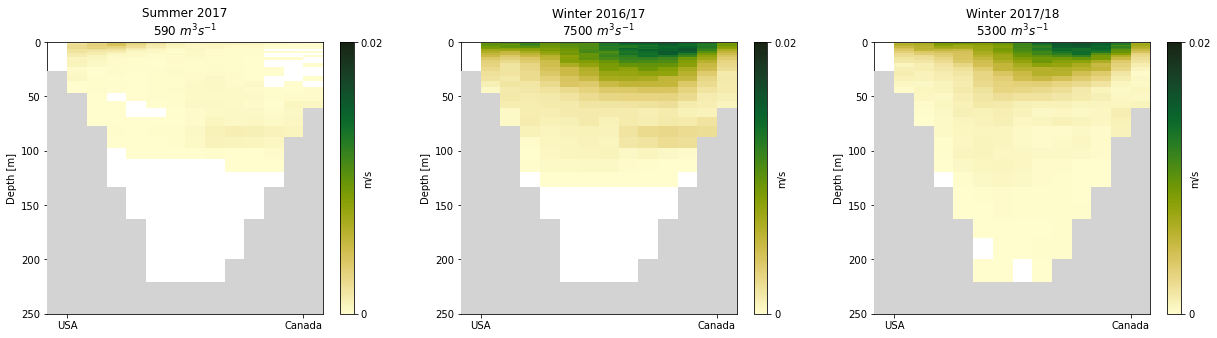

In [76]:
# fresh

#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200)& np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
title = "Summer 2017\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02)


#winter 2016/17

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
title = "Winter 2016/17\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02)

#winter 2017/18

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
title = "Winter 2017/18\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[2].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02)